# **All imports**

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# **Loading The Dataset**

In [87]:
orders = pd.read_csv('orders.csv')
users = pd.read_json('users.json')
print("Loaded orders and users dataset!")

print(orders.columns)
print(users.columns)

Loaded orders and users dataset!
Index(['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount',
       'restaurant_name'],
      dtype='object')
Index(['user_id', 'name', 'city', 'membership'], dtype='object')


In [ ]:
help(sqlite3)

# **Loading the restaurants.sql database in a dataframe**

In [88]:
cx = sqlite3.connect(":memory:")  # connect to a database in RAM

with open('restaurants.sql', 'r') as f:
    cx.executescript(f.read())
restaurants = pd.read_sql_query("SELECT * FROM restaurants", cx)
cx.close()

print(restaurants.columns)
print("restaurants dataset loaded successfully!")

Index(['restaurant_id', 'restaurant_name', 'cuisine', 'rating'], dtype='object')
restaurants dataset loaded successfully!


In [89]:
print("Orders shape:", orders.shape)
print("Users shape:", users.shape)
print("Restaurants shape:", restaurants.shape)

Orders shape: (10000, 6)
Users shape: (3000, 4)
Restaurants shape: (500, 4)


# **Merging all these dataset based on :**


Perform joins using keys:


*   orders.user_id → users.user_id
*   orders.restaurant_id → restaurants.restaurant_id

Join Type: Left Join (to retain all orders)



In [90]:
df1 = pd.merge(orders, users, on='user_id', how='left')
df = pd.merge(df1, restaurants, on='restaurant_id', how='left', suffixes=('_from_orders', '_from_restaurants'))

print(df.columns)


Index(['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount',
       'restaurant_name_from_orders', 'name', 'city', 'membership',
       'restaurant_name_from_restaurants', 'cuisine', 'rating'],
      dtype='object')


In [91]:
df = df.rename(columns={
    'restaurant_name_from_orders': 'restaurant_name_orders',
    'restaurant_name_from_restaurants': 'restaurant_name_master',
    'name': 'user_name'
})

In [92]:
df.to_csv('final_food_delivery_dataset.csv', index=False)


In [94]:
df = pd.read_csv('final_food_delivery_dataset.csv')
df['order_date'] = pd.to_datetime(df['order_date'],dayfirst=True)
df['quarter'] = df['order_date'].dt.quarter

# Which city has the highest total revenue (total_amount) from Gold members?

Q1: Chennai


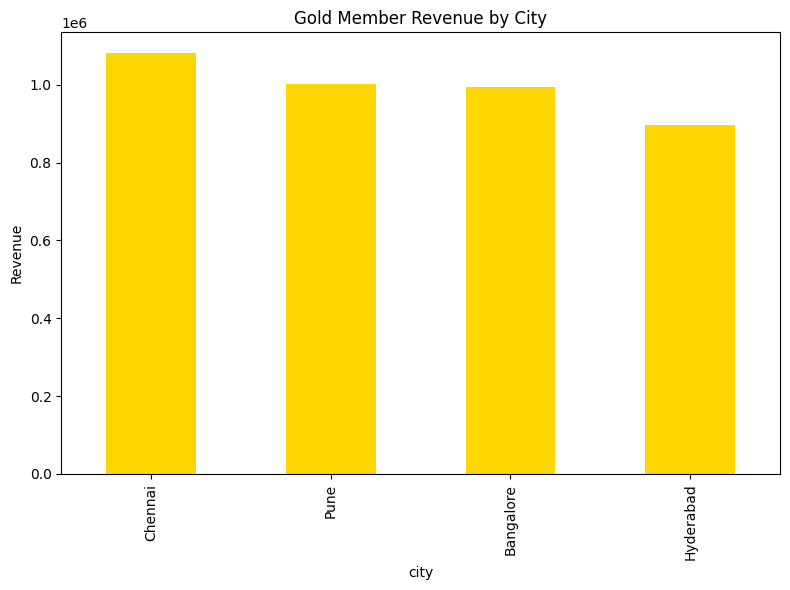

In [95]:

gold_data = df[df['membership'] == 'Gold']
result = gold_data.groupby('city')['total_amount'].sum()
print("\bQ1:", result.idxmax())

plt.figure(figsize=(8, 6))
result.sort_values(ascending=False).plot(kind='bar', color='gold')
plt.title('Gold Member Revenue by City')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


# Which cuisine has the highest average order value across all orders?

In [96]:
top_cuisine = df.groupby('cuisine')['total_amount'].mean().idxmax()
print(f"Q2. Highest avg order cuisine: {top_cuisine}")

Q2. Highest avg order cuisine: Mexican


# How many distinct users placed orders worth more than ₹1000 in total (sum of all their orders)?

In [97]:
user_totals = df.groupby('user_id')['total_amount'].sum()
high_value_users = (user_totals > 1000).sum()
if high_value_users < 500:
    bucket = "< 500"
elif high_value_users < 1000:
    bucket = "500 – 1000"
elif high_value_users < 2000:
    bucket = "1000 – 2000"
else:
    bucket = "> 2000"
print(f"Q3. Users with >₹1000 total: {bucket} ({high_value_users} users)")

Q3. Users with >₹1000 total: > 2000 (2544 users)


# Which restaurant rating range generated the highest total revenue?


Q4: 4.6 – 5.0


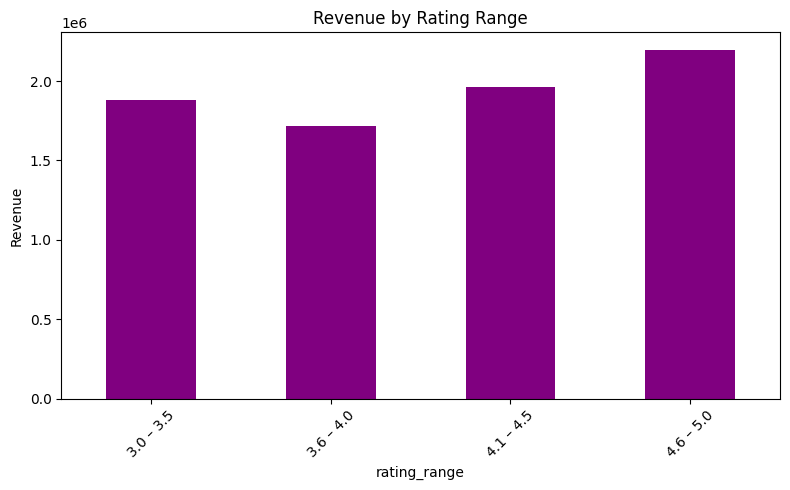

In [104]:
df['rating_range'] = pd.cut(
    df['rating'],
    bins=[3.0, 3.5, 4.0, 4.5, 5.0],
    labels=['3.0 – 3.5', '3.6 – 4.0', '4.1 – 4.5', '4.6 – 5.0']
)
result = df.groupby('rating_range', observed=False)['total_amount'].sum()
print("\nQ4:", result.idxmax())

plt.figure(figsize=(8, 5))
result.plot(kind='bar', color='purple')
plt.title('Revenue by Rating Range')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Among Gold members, which city has the highest average order value?

In [100]:
gold_avg_city = df[df['membership'] == 'Gold'].groupby('city')['total_amount'].mean().idxmax()
print(f"Q5. Highest Gold avg order city: {gold_avg_city}")

Q5. Highest Gold avg order city: Chennai


# Which cuisine has the lowest number of distinct restaurants but still contributes significant revenue?

In [105]:
stats = df.groupby('cuisine').agg({
    'restaurant_id': 'nunique',
    'total_amount': 'sum'
})
print("\nQ6:")
print(stats)


Q6:
         restaurant_id  total_amount
cuisine                             
Chinese            120    1930504.65
Indian             126    1971412.58
Italian            126    2024203.80
Mexican            128    2085503.09


# What percentage of total orders were placed by Gold members? (Rounded to nearest integer)

In [106]:
total = len(df)
gold = len(gold_data)
pct = round((gold / total) * 100)
print(f"\nQ7: {pct}%")



Q7: 50%


# Which restaurant has the highest average order value but less than 20 total orders?

In [107]:
resto_stats = df.groupby('restaurant_name_master').agg(
    avg_value=('total_amount', 'mean'),
    order_count=('order_id', 'count')
)
filtered = resto_stats[resto_stats['order_count'] < 20].sort_values('avg_value', ascending=False)
top_resto = filtered.index[0] if not filtered.empty else "N/A"
print(f"Q8. Highest avg value (<20 orders): {top_resto}")

Q8. Highest avg value (<20 orders): Restaurant_294


# Which combination contributes the highest revenue?

In [108]:
combo = df.groupby(['membership', 'cuisine'])['total_amount'].sum().idxmax()
print(f"Q9. Highest revenue combo: {combo[0]} + {combo[1]} cuisine")

Q9. Highest revenue combo: Regular + Mexican cuisine


# During which quarter of the year is the total revenue highest?

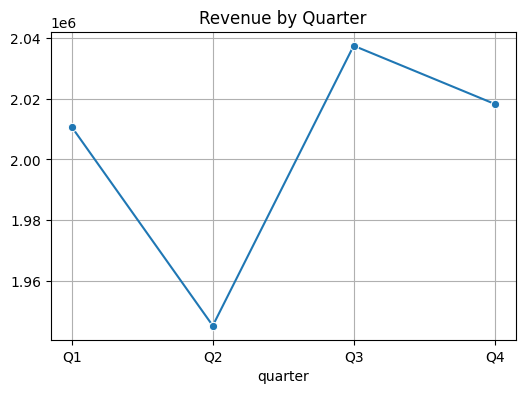

10. Highest Revenue Quarter: Q 3


In [62]:
df['quarter'] = df['order_date'].dt.quarter

q_rev = df.groupby('quarter')['total_amount'].sum()
top_quarter = q_rev.idxmax()

# Line Chart
plt.figure(figsize=(6, 4))
sns.lineplot(x=q_rev.index, y=q_rev.values, marker='o')
plt.title("Revenue by Quarter")
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True)
plt.show()

print("10. Highest Revenue Quarter: Q", top_quarter)

In [109]:

gold_orders = (df['membership'] == 'Gold').sum()
print(f"Q11. Total Gold member orders: {gold_orders}")


hyd_rev = df[df['city'] == 'Hyderabad']['total_amount'].sum()
print(f"Q12. Hyderabad total revenue: ₹{round(hyd_rev)}")


distinct_users = df['user_id'].nunique()
print(f"Q13. Distinct users with orders: {distinct_users}")


Q11. Total Gold member orders: 4987
Q12. Hyderabad total revenue: ₹1889367
Q13. Distinct users with orders: 2883


In [110]:

gold_avg = df[df['membership'] == 'Gold']['total_amount'].mean()
print(f"Q14. Gold member avg order value: ₹{gold_avg:.2f}")

high_rating_orders = (df['rating'] >= 4.5).sum()
print(f"Q15. Orders for 4.5★+ restaurants: {high_rating_orders}")


top_gold_city = df[df['membership'] == 'Gold'].groupby('city')['total_amount'].sum().idxmax()
city_orders = len(df[(df['city'] == top_gold_city) & (df['membership'] == 'Gold')])
print(f"Q16. Orders in top Gold city ({top_gold_city}): {city_orders}")


Q14. Gold member avg order value: ₹797.15
Q15. Orders for 4.5★+ restaurants: 3374
Q16. Orders in top Gold city (Chennai): 1337


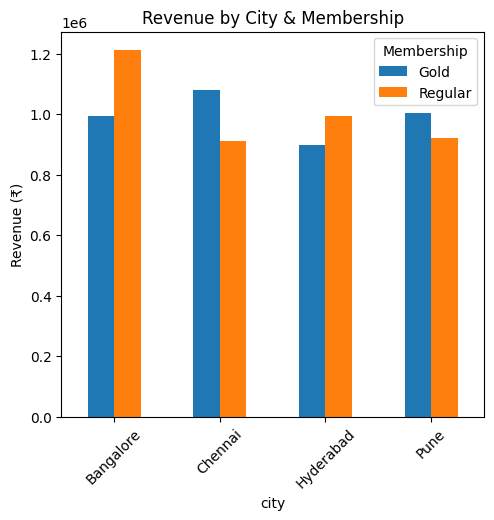

In [111]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
city_rev = df.groupby(['city', 'membership'])['total_amount'].sum().unstack()
city_rev.plot(kind='bar', ax=plt.gca())
plt.title('Revenue by City & Membership')
plt.ylabel('Revenue (₹)')
plt.xticks(rotation=45)
plt.legend(title='Membership')


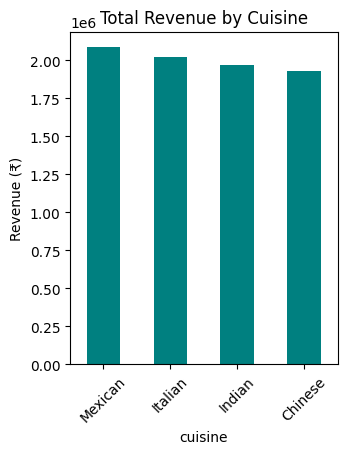

In [112]:
plt.subplot(1, 2, 2)
cuisine_perf = df.groupby('cuisine').agg(
    avg_order=('total_amount', 'mean'),
    total_rev=('total_amount', 'sum')
).sort_values('total_rev', ascending=False)
cuisine_perf['total_rev'].plot(kind='bar', color='teal')
plt.title('Total Revenue by Cuisine')
plt.ylabel('Revenue (₹)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()